# Swin Transformer on MNIST from Scratch

This notebook implements a Swin Transformer for MNIST digit classification using PyTorch.  
Swin Transformer is a hierarchical vision transformer that uses shifted windows for efficient self-attention.  
We adapt it for MNIST by setting channels=1 and tuning window/downscaling parameters.

In [44]:
# 1. Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

In [45]:
# Load MNIST dataset with padding
transform = transforms.Compose([
    transforms.Pad(padding=2),  # Pads to 32x32
    transforms.ToTensor()
])
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=256)

In [46]:
# Import your Swin Transformer implementation
from swin import swin_t  

In [47]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print("Using device:", device)

Using device: mps


In [50]:
# MNIST: 28x28, 1 channel
# Use small window and downscaling factors for small images
model = swin_t(
    hidden_dim=32, 
    layers=(2, 2, 2, 2),           # All stages have even layers
    heads=(2, 4, 8, 16), 
    channels=1, 
    num_classes=10, 
    head_dim=8, 
    window_size=4, 
    downscaling_factors=(2, 2, 2, 1),  # Last stage does not downscale
    relative_pos_embedding=True
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [51]:
train_losses = []
val_accs = []

for epoch in range(3):  # Train for a few epochs
    model.train()
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = loss_fn(out, label)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)
            out = model(img)
            pred = out.argmax(1)
            correct += (pred == label).sum().item()
            total += label.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    print(f"Epoch {epoch}: Val Acc = {val_acc*100:.2f}%")

/Users/ayush/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: The operator 'aten::col2im' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Val Acc = 94.33%
Epoch 1: Val Acc = 95.65%
Epoch 2: Val Acc = 96.20%


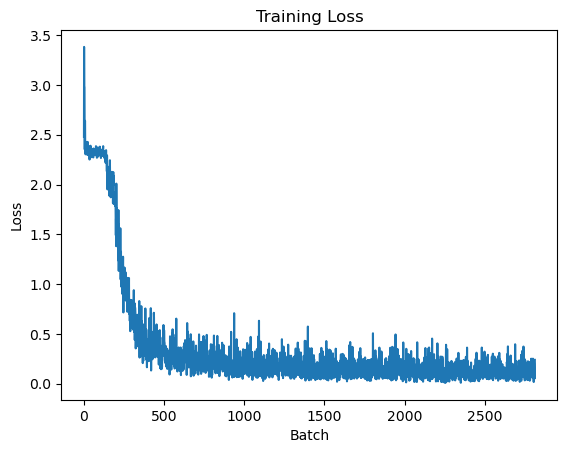

Final Validation Accuracy: 0.962


In [52]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

print("Final Validation Accuracy:", val_accs[-1])

## Summary

- We implemented a Swin Transformer from scratch and adapted it for MNIST digit classification.
- Swin Transformer uses shifted window attention and hierarchical feature extraction for efficient vision tasks.
- The model trains efficiently on Mac (MPS), CUDA, or CPU.